In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import janitor 

from influxdb_client import InfluxDBClient, Point, Dialect

import re

import time
import datetime

import warnings
from influxdb_client.client.warnings import MissingPivotFunction

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import matplotlib.colors as colors

# try:
#     # for Python2
#     from Tkinter import *   ## notice capitalized T in Tkinter 
# except ImportError:
#     # for Python3
#     from tkinter import *   ## notice lowercase 't' in tkinter here

pd.set_option('display.max_rows', 100)
import pandasql as ps
import sqlite3

In [2]:
#Read config file and load data into the variables

rx_dict = {
    'token': re.compile(r'var token = "(?P<token>.*)"\n'),
    'url': re.compile(r'var url = "(?P<url>.*)"\n'),
    'org': re.compile(r'var org = "(?P<org>.*)"\n'),
    'bucket': re.compile(r'var bucket = "(?P<bucket>.*)"\n'),
}

def _parse_line(line):
    """
    Do a regex search against all defined regexes and
    return the key and match result of the first matching regex

    """
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None



filepath = '/root/flexi-pipe/config.go'
# open the file and read through it line by line
with open(filepath, 'r') as file_object:
    line = file_object.readline()
    while line:
        # at each line check for a match with a regex
        key, match = _parse_line(line)

        if key == 'token':
            token = match.group('token')
        elif key == 'url':
            url = match.group('url')
        elif key == 'org':
            org = match.group('org')
        elif key == 'bucket':
            bucket = match.group('bucket')
        
        line = file_object.readline()


url="http://192.168.20.58:8086"

In [3]:
client = InfluxDBClient(url=url, token=token, org=org,  timeout=130_000)

# write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()

In [4]:
# Retrieve experiments data from csv
data = pd.read_csv('../experiments.csv', header=None)
df = pd.DataFrame(data)

#Rename columns
experiments = df.rename(columns={0: "start", 1: "end", 2: "topology", 3: "runtime", 4: "d", 5: "dlo", 6: "dhi", 7: "dscore", 8: "dlazy", 9: "dout", 10: "gossipFactor", 11: "initialDelay", 12: "interval"}, errors='raise')

#Correct timestamp
experiments["start"] = experiments["start"].str.slice(0, 27)
experiments["end"] = experiments["end"].str.slice(0, 27)

#String to timestamp
experiments['startUnix'] = pd.to_datetime(experiments["start"],format="%Y-%m-%d %H:%M:%S.%f").astype('int64') / 10**9
experiments['endUnix'] = pd.to_datetime(experiments["end"],format="%Y-%m-%d %H:%M:%S.%f").astype('int64') / 10**9

experiments['startUnix'] = pd.to_timedelta(experiments['startUnix'], unit='s').dt.total_seconds().astype(int)#.astype(str)
experiments['endUnix'] = pd.to_timedelta(experiments['endUnix'], unit='s').dt.total_seconds().astype(int)#.astype(str)

#Drop fields we don't mneed for the moment
exp = experiments.drop(columns=["runtime", "initialDelay"]).sort_values(by=["start"])

exp.head(100)

,start,end,topology,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,startUnix,endUnix
0,2023-08-01 18:12:39.9235463,2023-08-01 18:27:39.9823849,validator,8,6,12,4,8,2,0.25,0.5,1690913559,1690914459
1,2023-08-01 18:31:11.7897611,2023-08-01 18:46:11.8497848,validator,8,6,12,4,8,2,0.25,1.0,1690914671,1690915571
4,2023-08-01 19:26:50.4773509,2023-08-01 19:41:50.4791575,validator,12,6,12,4,8,2,0.25,1.0,1690918010,1690918910
2,2023-08-01 20:03:55.9990248,2023-08-01 20:18:56.0023639,validator,8,3,12,4,8,2,0.25,1.0,1690920235,1690921136
3,2023-08-01 20:22:28.8777816,2023-08-01 20:37:28.8852009,validator,8,6,12,6,8,2,0.25,1.0,1690921348,1690922248
5,2023-08-02 10:56:20.4955665,2023-08-02 11:11:20.4982340,general,8,6,12,4,8,2,0.25,0.5,1690973780,1690974680
6,2023-08-02 11:14:47.7918974,2023-08-02 11:29:47.8618204,general,8,6,12,4,8,2,0.25,1.0,1690974887,1690975787
7,2023-08-02 12:54:05.2745963,2023-08-02 13:09:05.2774139,unl,8,6,12,4,8,2,0.25,0.5,1690980845,1690981745
8,2023-08-02 13:12:29.3626010,2023-08-02 13:27:29.4399914,unl,8,6,12,4,8,2,0.25,1.0,1690981949,1690982849
9,2023-08-02 13:49:24.3574194,2023-08-02 14:04:24.3707622,unl,8,6,12,4,8,2,0.25,3.0,1690984164,1690985064


In [5]:
#Get times for different intervals
# intervals = exp["interval"].drop_duplicates().sort_values().reset_index(drop=True)
# intervals.head(10)

expTime = exp[exp['startUnix'].astype(int).between(1691423149, 1691473008)]
expTime = expTime.reset_index().rename({'index':'experiment'}, axis = 'columns')

expTime.head(20)

,experiment,start,end,topology,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,startUnix,endUnix
0,22,2023-08-07 15:45:49.6082919,2023-08-07 16:00:49.6665551,general,8,6,12,4,8,2,0.25,0.5,1691423149,1691424049
1,23,2023-08-07 16:04:21.6318119,2023-08-07 16:19:21.6346074,general,8,6,12,4,8,2,0.25,0.5,1691424261,1691425161
2,24,2023-08-07 16:22:53.6132934,2023-08-07 16:37:53.6715174,general,8,6,12,4,8,2,0.25,0.5,1691425373,1691426273
3,25,2023-08-07 16:41:26.1245354,2023-08-07 16:56:26.1290839,general,8,6,12,4,8,2,0.25,1.0,1691426486,1691427386
4,26,2023-08-07 16:59:58.1176366,2023-08-07 17:14:58.1206094,general,8,6,12,4,8,2,0.25,1.0,1691427598,1691428498
5,27,2023-08-07 17:18:30.6060026,2023-08-07 17:33:30.6091742,general,8,6,12,4,8,2,0.25,1.0,1691428710,1691429610
6,28,2023-08-07 17:37:02.4851057,2023-08-07 17:52:02.5670752,general,8,6,12,4,8,2,0.25,30.0,1691429822,1691430722
7,29,2023-08-07 17:55:34.7527963,2023-08-07 18:10:34.7603854,general,8,6,12,4,8,2,0.25,30.0,1691430934,1691431834
8,30,2023-08-07 18:14:06.9060147,2023-08-07 18:29:06.9662688,general,8,6,12,4,8,2,0.25,30.0,1691432046,1691432946
9,31,2023-08-07 18:32:38.9738532,2023-08-07 18:47:38.9763238,general,8,6,12,4,8,2,0.25,3.0,1691433158,1691434058


In [6]:
data_frame = query_api.query_data_frame('from(bucket: "gs") '
                                        ' |> range(start: 1691423149, stop:1691436284) '
                                        ' |> filter(fn: (r) => r._measurement == "message") '
                                        ' |> group(columns: ["_measurement", "_field"], mode: "by") '
                                        ' |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")')
client.close()
data_frame.head(10)

,result,table,_start,_stop,_time,_measurement,type
0,_result,0,2023-08-07 15:45:49+00:00,2023-08-07 19:24:44+00:00,2023-08-07 15:55:37.268012+00:00,message,9.0
1,_result,0,2023-08-07 15:45:49+00:00,2023-08-07 19:24:44+00:00,2023-08-07 15:55:37.276040+00:00,message,4.0
2,_result,0,2023-08-07 15:45:49+00:00,2023-08-07 19:24:44+00:00,2023-08-07 15:55:37.276530+00:00,message,6.0
3,_result,0,2023-08-07 15:45:49+00:00,2023-08-07 19:24:44+00:00,2023-08-07 15:55:37.276979+00:00,message,6.0
4,_result,0,2023-08-07 15:45:49+00:00,2023-08-07 19:24:44+00:00,2023-08-07 15:55:37.277153+00:00,message,4.0
5,_result,0,2023-08-07 15:45:49+00:00,2023-08-07 19:24:44+00:00,2023-08-07 15:55:37.277282+00:00,message,6.0
6,_result,0,2023-08-07 15:45:49+00:00,2023-08-07 19:24:44+00:00,2023-08-07 15:55:37.279461+00:00,message,4.0
7,_result,0,2023-08-07 15:45:49+00:00,2023-08-07 19:24:44+00:00,2023-08-07 15:55:37.310546+00:00,message,4.0
8,_result,0,2023-08-07 15:45:49+00:00,2023-08-07 19:24:44+00:00,2023-08-07 15:55:37.311180+00:00,message,6.0
9,_result,0,2023-08-07 15:45:49+00:00,2023-08-07 19:24:44+00:00,2023-08-07 15:55:37.315899+00:00,message,6.0


In [7]:
# df = data_frame.drop(columns=['result', 'table','_start', '_stop', '_measurement', 'topic', 'receivedFrom']).sort_values(by=["_time"]).reset_index(drop=True)
# df["_time"] = pd.to_datetime(df["_time"])
df = data_frame[['_time', "type"]].sort_values(by=["_time"]).reset_index(drop=True)
df["_time"] = pd.to_datetime(df["_time"])

df.head(10)

,_time,type
0,2023-08-07 15:45:50.103451+00:00,6.0
1,2023-08-07 15:45:50.103630+00:00,0.0
2,2023-08-07 15:45:50.103797+00:00,6.0
3,2023-08-07 15:45:50.103843+00:00,6.0
4,2023-08-07 15:45:50.103852+00:00,6.0
5,2023-08-07 15:45:50.103998+00:00,6.0
6,2023-08-07 15:45:50.104036+00:00,6.0
7,2023-08-07 15:45:50.104047+00:00,2.0
8,2023-08-07 15:45:50.104049+00:00,2.0
9,2023-08-07 15:45:50.104058+00:00,3.0


In [8]:
#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
df.to_sql('df', conn, index=False)
expTime.to_sql('expTime', conn, index=False)

qry = '''
    select  
        df._time,
        df.type,
        expTime.experiment,
        expTime.interval
    from
        df join expTime on
        df._time between expTime.start and expTime.end
    '''
dfNew = pd.read_sql_query(qry, conn)

dfNew = dfNew.set_index('experiment').rename(columns={"_time": "min"})#.drop(columns=["messageID"])

dfNew['min'] = pd.to_datetime(dfNew["min"], format='mixed')
# dfNew['_min'] = pd.to_datetime(dfNew["_min"])

dfNew.head(20)

,min,type,interval
experiment,,,
22,2023-08-07 15:45:50.103451+00:00,6.0,0.5
22,2023-08-07 15:45:50.103630+00:00,0.0,0.5
22,2023-08-07 15:45:50.103797+00:00,6.0,0.5
22,2023-08-07 15:45:50.103843+00:00,6.0,0.5
22,2023-08-07 15:45:50.103852+00:00,6.0,0.5
22,2023-08-07 15:45:50.103998+00:00,6.0,0.5
22,2023-08-07 15:45:50.104036+00:00,6.0,0.5
22,2023-08-07 15:45:50.104047+00:00,2.0,0.5
22,2023-08-07 15:45:50.104049+00:00,2.0,0.5


In [9]:
#Try resampling for every 5 seconds
dfNoIndex = dfNew.reset_index()
# dfNoIndex.head(10)

by_time = dfNoIndex.groupby([dfNoIndex['experiment'],dfNoIndex['interval'],pd.Grouper(key="min", freq='10s')])['type'].count().reset_index()
dfAggTime = by_time.rename(columns={"type": "count"})


dfAggTime.head(100)

,experiment,interval,min,count
0,22,0.5,2023-08-07 15:45:50+00:00,15681
1,22,0.5,2023-08-07 15:46:00+00:00,7366
2,22,0.5,2023-08-07 15:46:20+00:00,323
3,22,0.5,2023-08-07 15:46:30+00:00,201
4,22,0.5,2023-08-07 15:46:40+00:00,325
5,22,0.5,2023-08-07 15:47:00+00:00,200
6,22,0.5,2023-08-07 15:47:30+00:00,199
7,22,0.5,2023-08-07 15:48:00+00:00,200
8,22,0.5,2023-08-07 15:52:00+00:00,14
9,22,0.5,2023-08-07 15:55:30+00:00,1733


In [10]:
# Fill the voids
minTime = dfAggTime.groupby(['experiment']).agg('min').drop(columns=['count'])
maxTime = dfAggTime.groupby(['experiment']).agg('max').drop(columns=['count'])
# maxTime.head(10)

minMax = minTime.merge(maxTime, on=['experiment']).rename(columns={"min_x": "min", "min_y": "max", "interval_x": "interval"}).drop(columns=['interval_y']).reset_index()
# minMax.head(10)

date_list = pd.date_range(minMax['min'].min(), minMax['max'].max(),freq='10s')

dates = pd.DataFrame(date_list).rename(columns={0:"_time"})
dates['count'] = 0

#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
minMax.to_sql('minMax', conn, index=False)
dates.to_sql('dates', conn, index=False)

qry = '''
    select  
        dates._time as _time,
        minMax.interval,
        minMax.experiment,
        dates.count
    from
        dates join minMax on
        dates._time between minMax.min and minMax.max
    '''
dfFill = pd.read_sql_query(qry, conn)
# dfFill.head(10)
# print(dfFill)
print(dfAggTime)

#write the tables
dfFill.to_sql('fill', conn, index=False)
dfAggTime.to_sql('df', conn, index=False)

qry = '''
    select
       experiment,
       interval,
       _time as min,
       count
    from fill
    where fill._time not in (SELECT DISTINCT min FROM df)
    '''
dfMissingTime = pd.read_sql_query(qry, conn).reset_index(drop=True).drop_duplicates()
# print(dfMissingTime)
dfMissingTime['min'] = pd.to_datetime(dfMissingTime["min"], format='mixed')
# dfNew['min'] = pd.to_datetime(dfNew["min"], format='mixed')

dfAggTime =  pd.concat([dfMissingTime.reset_index(drop=True), dfAggTime.reset_index(drop=True)]).sort_values(by=['min'])
dfAggTime.head(200)

     experiment  interval                       min  count
0            22       0.5 2023-08-07 15:45:50+00:00  15681
1            22       0.5 2023-08-07 15:46:00+00:00   7366
2            22       0.5 2023-08-07 15:46:20+00:00    323
3            22       0.5 2023-08-07 15:46:30+00:00    201
4            22       0.5 2023-08-07 15:46:40+00:00    325
..          ...       ...                       ...    ...
681          33       3.0 2023-08-07 19:24:00+00:00  29920
682          33       3.0 2023-08-07 19:24:10+00:00  29928
683          33       3.0 2023-08-07 19:24:20+00:00  37268
684          33       3.0 2023-08-07 19:24:30+00:00  31353
685          33       3.0 2023-08-07 19:24:40+00:00  10222

[686 rows x 4 columns]


,experiment,interval,min,count
0,22,0.5,2023-08-07 15:45:50+00:00,15681
1,22,0.5,2023-08-07 15:46:00+00:00,7366
0,22,0.5,2023-08-07 15:46:10+00:00,0
2,22,0.5,2023-08-07 15:46:20+00:00,323
3,22,0.5,2023-08-07 15:46:30+00:00,201
...,...,...,...,...
81,24,0.5,2023-08-07 16:25:10+00:00,0
82,24,0.5,2023-08-07 16:25:20+00:00,0
83,24,0.5,2023-08-07 16:25:30+00:00,0
84,24,0.5,2023-08-07 16:25:40+00:00,0


In [11]:
#Min datetime of each experiment
minTime = dfAggTime.groupby(['experiment']).agg('min').drop(columns=['interval', 'count'])

# minTime.head(20)

#Join to calculate delta
dfWithMin = dfAggTime.merge(minTime, on='experiment', how='left').rename(columns={'min_x': '_time', 'min_y': '_min'})

dfWithMin['_time'] = pd.to_datetime(dfWithMin["_time"], format='mixed')
dfWithMin['_min'] = pd.to_datetime(dfWithMin["_min"],  format='mixed')

# #Calculate delta in seconds 
dfWithMin["delta"] = ((dfWithMin["_time"] - dfWithMin["_min"]) / pd.Timedelta(seconds=1)).astype(int)

# dfWithMin.head(100)

#Aggregate by time
gb = dfWithMin.groupby(['delta','experiment', 'interval'])['count'].agg(["sum"]).sort_values(by=["experiment", "delta"])
# gb.columns = gb.columns.droplevel(0)
# gb.reset_index(level=0, inplace=True)

# gb.head(100)

#Average by interval
intv = gb.groupby(['interval','delta']).agg(["mean"]).sort_values(by=["interval", "delta"])
intv.columns = intv.columns.droplevel(0)#.droplevel(1)
# intv.reset_index(level=0, inplace=True)
intv.reset_index(inplace=True)

intv.head(10)

,interval,delta,mean
0,0.5,0,11073.333333
1,0.5,10,9530.333333
2,0.5,20,3232.333333
3,0.5,30,3348.666667
4,0.5,40,3432.666667
5,0.5,50,3339.333333
6,0.5,60,3231.333333
7,0.5,70,3442.333333
8,0.5,80,3234.000000
9,0.5,90,3238.000000


In [12]:
# get intervals

intervals = intv['interval'].drop_duplicates().to_numpy()

# print(intervals)

for interval in np.nditer(intervals):
    print(interval)
    aux = intv.loc[intv["interval"] == interval]

aux.head(10)


0.5
1.0
3.0
30.0


,interval,delta,mean
273,30.0,0,10312.333333
274,30.0,10,19831.666667
275,30.0,20,12905.666667
276,30.0,30,9745.333333
277,30.0,40,9978.000000
278,30.0,50,10297.000000
279,30.0,60,9449.000000
280,30.0,70,9503.666667
281,30.0,80,9727.000000
282,30.0,90,8995.666667


FileNotFoundError: [Errno 2] No such file or directory: './figures/messOverheadInterval.pdf'

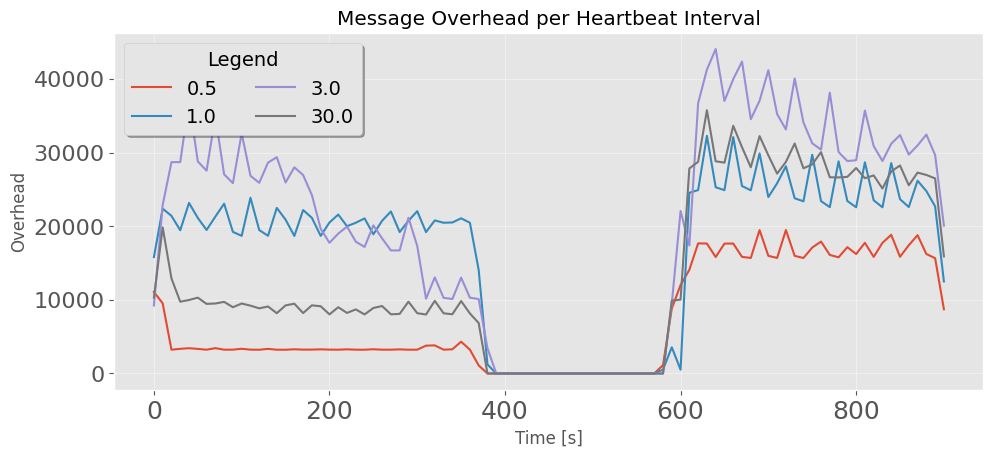

In [13]:
plt.style.use('ggplot')
# kwargs = dict(color=['hotpink'], alpha=0.9)#, density=True)

fig, ax = plt.subplots(constrained_layout=False)
ax.grid(alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.gca().set(title='Message Overhead per Heartbeat Interval', ylabel='Overhead', xlabel="Time [s]")

plt.rcParams.update({'font.size': 14})
# plt.hist([x1, x2, x6], **kwargs, label=['GS 1 topic', 'Vanilla', 'Squelching'])
# plt.legend(loc='upper center', bbox_to_anchor=(0.58, 1))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)

fig.set_size_inches(11, 4.3)

for interval in np.nditer(intervals):
    aux = intv.loc[intv["interval"] == interval]
    interv = aux["interval"].drop_duplicates().item()
    plt.plot(aux["delta"], aux["mean"], label=interv)

ax.legend(loc="upper left", bbox_to_anchor=[0, 1],
                 ncols=2, shadow=True, title="Legend", fancybox=True)

fig.savefig('./figures/messOverheadInterval.pdf', format='pdf', facecolor='white', edgecolor='none', bbox_inches='tight', dpi=600)
fig.savefig('./figures/messOverheadInterval.png', format='png', facecolor='white', edgecolor='none', bbox_inches='tight', dpi=600)

plt.show()